# BASIC CONTROLLERS

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_13_14-Closed-Loop-Systems/Closed-Loop-System.png?raw=true"
     alt="Markdown Monster icon" width=600pt
     style="float: left; margin-right: 10px;" />

This notebook describes the proportional, integral, and differential controllers.

# Preliminaries

In [19]:
!pip install -q control
!pip install -q tellurium
!pip install -q controlSBML

import control
import controlSBML as ctl
from IPython.display import HTML, Math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy
import tellurium as te

In [20]:
TIMES = ctl.makeSimulationTimes(0, 5, 500)

# Antimony Model

In [21]:
# Constants
CONSTANT_DCT = {"k1": 1, "k2": 2, "k3": 3, "k4": 4}
s = sympy.Symbol("s")
REF = 10

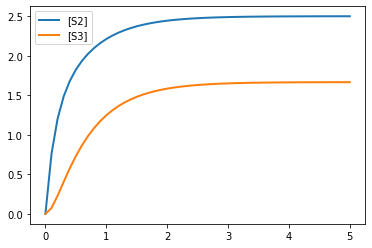

In [22]:
MODEL = """
$S1 -> S2; k1*$S1
J1: S2 -> S3; k2*S2
J2: S3 -> S2; k3*S3
J3: S2 -> ; k4*S2

k1 = 1
k2 = 2
k3 = 3
k4 = 4
$S1 = 10
S2 = 0
S3 = 0
S4 = 0
"""
RR = te.loada(MODEL)
RR.simulate()
RR.plot()

# PID Controllers

The controllers considered here are systems that input the control error and produce a control signal used
to regulate the system under control.
The input signal is $e(t)$ and the output signal is $u(t)$.

A **proportional controller** has the parameter $k_P$.
This controller outputs a signal that is proportional to the control error.
That is, $u(t) = k_P e(t)$.
The transfer function for this controller is $H_{P} (s) = k_p$.

An **integral controller** has the parameter $k_I$.
This controller outputs a signal that is proportional to the *integral* of the control error.
That is, $u(t) = k_I \int_0^{t} e(\tau) d \tau$.
The transfer function for this controller is $H_{I} (s) = \frac{k_I}{s}$.

An **differential controller** has the parameter $k_D$.
This controller outputs a signal that is proportional to the derivative of the control error.
That is, $u(t) = k_D \frac{de(t)}{d t}$.
The transfer function for this controller is $H_{D} (s) = k_D s$.

These controllers can be used in combination.
For example, a PI controller produces $u(t) = k_P e(t) +  k_I \int_0^{t} e(\tau) d \tau + k_D \frac{d e(t)}{d t}$,
and its transfer function is $H_{PID}(s) = k_P + \frac{k_I}{s} + k_D s$.
$H_{PID} = \frac{s k_P + k_I + s^2 k_D}{s}$.


# Analysis in Discrete Time

To improve our understanding of the different types of control, we'll do an analysis in discrete time.
Let $n$ index the instances.
Consider an input signal $e_n$ and an output signal $u_n$. Here's how the controllers work:
* **Proportional control**. $u_n = k_P e_n$
* **Integral control**. $u_n = k_I \sum_{i=0}^n e_i$
* **Differential control**. $u_n = k_D (e_n - e_{n-1})$

Now let's create an envaluation environment.

## Analysis Codes

In [36]:
def evaluateController(e_vec, kp=0, ki=0, kd=0, ax=None, is_plot=True):
    """
    Plots the output of the controller for the signal.
    
    Parameters
    ----------
    e_vec: list-float
    kp: float
    ki: float
    kd: float
    
    Returns
    -------
    np.array
    """
    u_vec = []
    e_last = 0
    e_sum = 0
    for e_val in e_vec:
        e_sum  += e_val
        #
        u_val = kp*e_val
        u_val += ki*e_sum
        u_val += kd*(e_val - e_last)
        u_vec.append(u_val)
        #
        e_last = e_val
    #
    if is_plot:
        if ax is None:
            _, ax = plt.subplots(1)
        times = range(len(u_vec))
        ax.plot(range(len(u_vec)), u_vec, color="blue")
        y_vec = e_vec[0:len(times)]
        ax.plot(times, y_vec, linestyle="--", color="black")
        ax.legend(["u(t)", "e(t)"])
        ax.set_xlabel("time")
        ax.set_ylim([-1.5, 1.5])
    return np.array(u_vec)
             
# Tests
e_vec = np.repeat(1, 10)
u_vec = evaluateController(e_vec, kp=1, ki=1, kd=1, is_plot=False)
assert(u_vec[0] == 3)
print("OK!")

OK!


## Analysis

What signals should we consider for $e(t)$?

In [42]:
step_input

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

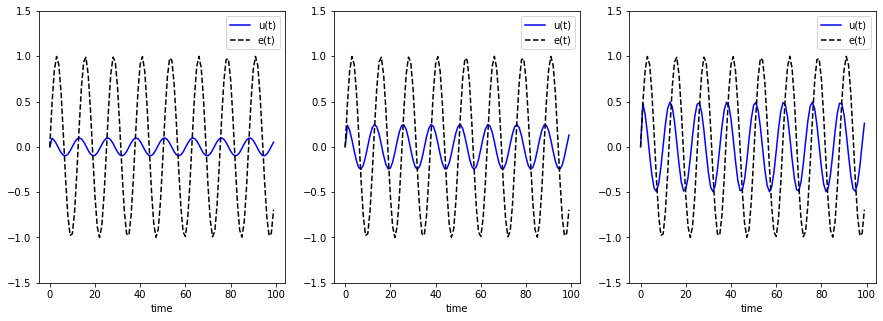

In [45]:
sine_input = np.sin(0.5*np.array(range(100)))
_, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx, kd in enumerate([0.2, 0.5, 1]):
    _ = evaluateController(sine_input, kd=kd, ax=axes[idx])

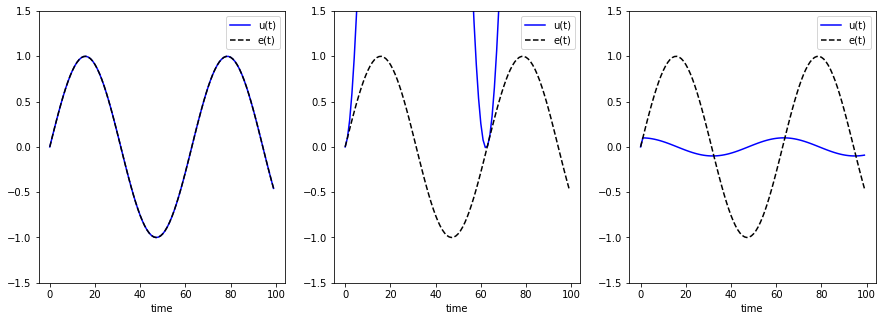

In [24]:
step_input = np.repeat(1, 10)
step_input = np.sin(0.1*np.array(range(100)))
_, axes = plt.subplots(1, 3, figsize=(15, 5))
_ = evaluateController(step_input, kp=1, ax=axes[0])
_ = evaluateController(step_input, ki=1, ax=axes[1])
_ = evaluateController(step_input, kd=1, ax=axes[2])

# Analysis in Continuous Time

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_13_14-Closed-Loop-Systems/Closed-Loop-System.png?raw=true"
     alt="Markdown Monster icon" width=600pt
     style="float: left; margin-right: 10px;" />

We can analyze controllers by looking at their transfer functions by considering poles, DC gain, and step respoinse.

$H_{PID} (s) = H_P(s) + H_I(s) + H_D(s) =  k_P + \frac{k_I}{s} + s k_D$

## Analysis Codes

In [25]:
def plotPIDStepResponse(kp=1, ki=0, kd=0, is_plot=True):
    """
    Plots the step response of the PID controller.
    
    Parameters
    ----------
    kp: float
    ki: float
    kd: float
    is_plot: bool
    
    Returns
    -------
    control.TransferFunction
    """
    tf = control.TransferFunction([kp], [1])  \
          + control.TransferFunction([ki], [1, 0])  \
          + control.TransferFunction([kd, 0], [1])
    if is_plot:
        if len(tf.num[0][0]) > len(tf.den[0][0]):
            print("Improper transfer function. Cannot simulate.")
        else:
            result = control.step_response(tf)
            plt.plot(result.t.flatten(), result.y.flatten())
    return tf

# Tests
tf = plotPIDStepResponse(kp=1, ki=0, kd=0, is_plot=False)
assert(tf.dcgain() == 1)
print("OK!")

OK!


In [26]:
# Find the DC gains for different variations of controllers
print("kp=1: %2.2f" % plotPIDStepResponse(kp=1, ki=0, kd=0, is_plot=False).dcgain())
print("ki=1: %2.2f" % plotPIDStepResponse(kp=0, ki=1, kd=0, is_plot=False).dcgain())

kp=1: 1.00
ki=1: inf


## Controller in Closed Loop

### Extending ``plotTF`` to PID Controllers

In [60]:
def plotTFs(Gs, kp, ki, times=TIMES, ylim=None, title=None, is_plot=True):
    """
    Constructs the transfer functions for the proportional controller, and filter.
    Calculates the transfer functions HRYs, HREs, HNYs, HDYs and plots them.
    
    Parameters
    ----------
    Gs: control.TransferFunction
    k_p: float
    k_i: float
    times: list-float
    ylim: (float, float)
        limits of y-values
    title: str
    
    Returns
    -------
    dct
        key: name of transfer function
        value: control.TransferFunction
    """
    Cs = control.TransferFunction([kp], [1]) + control.TransferFunction([ki], [1, 0])
    Fs = 1
    denom = 1 + Cs*Gs*Fs
    # Construct the transfer functions
    tf_dct = {
        "HRYs": Cs*Gs/denom,
        "HREs": 1/denom,
        "HNYs": -Fs/denom,
        "HDYs": Cs/denom,
    }
    # Construct the plots
    _, ax = plt.subplots(1)
    for tf in tf_dct.values():
        result = control.forced_response(tf, T=times, U=1)
        plt.plot(result.t.flatten(), result.y.flatten())
    # Refine plots
    plt.legend(list(tf_dct.keys()))
    xmax = max(result.t.flatten())
    plt.plot([0, xmax], [0, 0], linestyle="--", color="black")
    plt.plot([0, xmax], [1, 1], linestyle="--", color="grey")
    plt.ylim([-5, 5])
    title = "kp=%2.2f ki=%2.2f" % (kp, ki)
    plt.title(title)
    if not is_plot:
        plt.close()
    return tf_dct
    
# Tests
Gs = control.TransferFunction([2], [1, 3])
dct = plotTFs(Gs, 10, 10, ylim=[0, 3], title="Example", is_plot=False)
assert(len(dct) == 4)
assert("TransferFunction" in str(type(dct["HRYs"])))
print("OK!")

OK!


### Plots

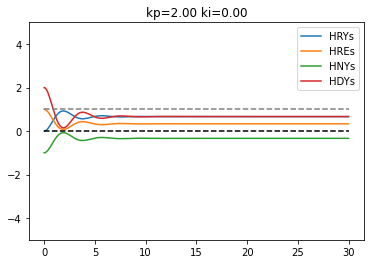

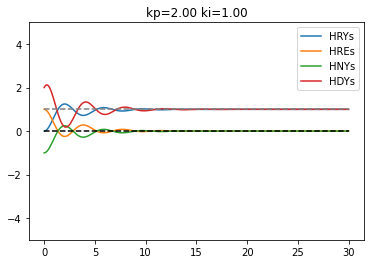

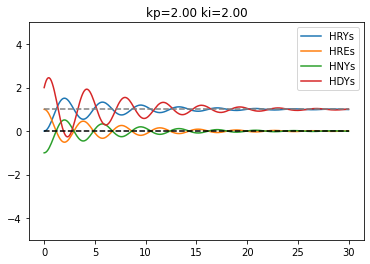

In [63]:
Gs = control.TransferFunction([1], [1, 1, 1])
times = ctl.makeSimulationTimes(end_time=30)
for k_p in [2]:
    for k_i in [0, 1, 2 ]:
        title = "k_p: %2.1f k_i: %2.1f" % (k_p, k_i)
        _ = plotTFs(Gs, k_p, k_i, title=title, times=times, ylim=[-1, 3])

# Testbed

## Controller Factory

**We need to extend ``makeController`` to PID**

In [29]:
# Extend to PID
def makeController(name, kp=2):
    """
    Creates a proportional controller as a NonlinearIOSystem with input "in" and output "out".
    
    Parameters
    ----------
    name: str
        Name of the system
    kp: float
    
    Returns
    -------
    control.NonlinearIOSystem
    """
    def outfcn(_, __, u, ___):
        # u: float (error signal)
        if not "len" in dir(u):
            u = [u]
        return kp*(u[0])
    #
    return control.NonlinearIOSystem(
        None, outfcn, inputs=['in'], outputs=['out'],
        name=name)

# Tests
kp = 2
controller = makeController("controller", kp=kp)
times = [0, 1, 2, 3, 4]
result = control.input_output_response(controller, T=times, U=times)
trues = [r == kp*( t) for t, r in zip(result.t, result.outputs)]
assert(all(trues))
print("OK!")

OK!


## Closed Loop System

In [30]:
# Elements of the system
ref = 3

factory = ctl.IOSystemFactory()
# Create the elements of the feedback loop
reference = factory.makeMultiplier("reference", ref)
noise = factory.makeSinusoid("noise", 0.01, 20)
disturbance = factory.makeSinusoid("disturbance", 5, 2)

ctlsb = ctl.ControlSBML(MODEL, input_names=["S2"], output_names=["S3"])
system = ctlsb.makeNonlinearIOSystem("system")
controller = makeController("controller", kp=1)
fltr = factory.makeFilter("fltr", -100)

sum_Y_N = factory.makeAdder("sum_Y_N")
sum_U_D = factory.makeAdder("sum_U_D")
sum_R_F = factory.makeAdder("sum_R_F")

In [31]:
# Create the closed loop system
closed_loop = control.interconnect(
  [reference, noise, disturbance, sum_Y_N, sum_R_F, sum_U_D, system, fltr, controller ], 
  connections=[
    ['controller.in', 'sum_R_F.out'],    # e(t)
    ['sum_U_D.in1', 'controller.out'],   # u(t)
    ['sum_U_D.in2', 'disturbance.out'],  # d(t)
    ['system.S2',   'sum_U_D.out'],
    ['sum_Y_N.in1', 'system.S3'],        # y(t)
    ['sum_Y_N.in2', 'noise.out'],        # n(t)
    ['fltr.in',     'sum_Y_N.out'],
    ['sum_R_F.in1', '-fltr.out'],
    ['sum_R_F.in2', 'reference.out'],
  ],
  inplist=["reference.in"],
  outlist=["disturbance.out", "sum_Y_N.out", 'sum_R_F.out', 'system.S3'],
)

## Plots

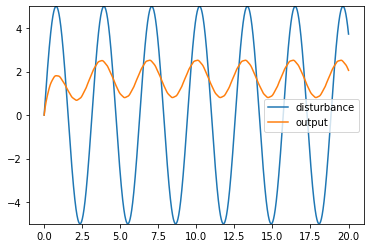

In [32]:
times = ctl.makeSimulationTimes(0, 20, 500)
result = control.input_output_response(closed_loop, T=times, U=1)
plt.plot(result.t, result.outputs[0].flatten())
plt.plot(result.t, result.outputs[1].flatten())
plt.ylim([-5, 5])
legends = ["disturbance", "output"]
plt.legend(legends)

The output is biased! We wanted $S_3$ to be 10, but it's 7.6.

# More On Filters

How do filters help with sinusoidal noise and disturbances?

In [33]:
# Create a testsbed
factory = ctl.IOSystemFactory()
fltr = factory.makeFilter("fltr", -50)
noise = factory.makeSinusoid("noise", 1, 20)

In [34]:
# Create the testbed
test_bed = control.interconnect(
  [noise, fltr ], 
  connections=[
    ['fltr.in', 'noise.out'],    # e(t)
    
  ],
  outlist=["fltr.out"],
)

(-1.0, 1.0)

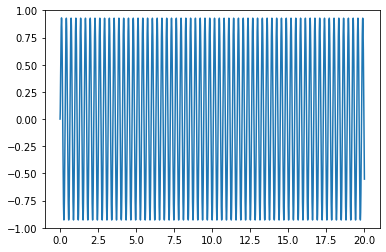

In [35]:
# Simulate it
times = ctl.makeSimulationTimes(0, 20, 500)
result = control.input_output_response(test_bed, T=times)
plt.plot(result.t, result.outputs.flatten())
plt.ylim([-1, 1])